# Using Latent Dirichlet Allocation (LDA) to Topic Model

This notebook contains the entire project from data cleaning to final results. The reason everything is in one notebook is because when reading in a cleaned data frame, then preprocessing, then attempting to train the model, the model throws errors about the data types. For ease of navigating the notebook, below is a table of contents.

I: [Cleaning](#I:-Initial-cleaning)

II: [EDA](#II:-EDA)

III : [Preprocessing](#III:-Preprocessing)

III: [Modeling](#IV:-Modeling)

IV: [Sentiment Analysis](#V:-Performing-Sentiment-Analysis-on-the-Years-2019-2021)

V: [Conclusions and Recommendations](#Conclusions-and-Recommendations)

Click [here](#end) to go to the bottom of the notebook


## I: Initial cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('./data/the-antiwork-subreddit-dataset-posts.csv')
print(df.shape)
df.head()

(256279, 12)


,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,svw6x3,2y77d,antiwork,False,1645228719,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,I was hired at the **Neon Museum** as a tour g...,Neon Museum Las Vegas took away our tips,15
1,post,svw6jv,2y77d,antiwork,False,1645228687,https://old.reddit.com/r/antiwork/comments/svw...,i.redd.it,https://i.redd.it/vuoctaq0koi81.png,NaN,Working,1887
2,post,svw5e8,2y77d,antiwork,False,1645228588,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,"So, I'm quite new to the jobs front then most ...",Kind of feel like screaming into the cyberspace,4
3,post,svw498,2y77d,antiwork,False,1645228495,https://old.reddit.com/r/antiwork/comments/svw...,i.redd.it,https://i.redd.it/1w1unxjfjoi81.png,NaN,"Democracy is a lie, especially in the modern w...",14060
4,post,svw3qt,2y77d,antiwork,False,1645228450,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,My boss asked me today what I plan on doing wh...,Master's Degree - No Pay Raise but OT,63


In [3]:
df.nunique()

type                   1
id                256279
subreddit.id           1
subreddit.name         1
subreddit.nsfw         1
created_utc       253907
permalink         256279
domain              5126
url                93951
selftext           83301
title             238727
score               7860
dtype: int64

Because in each of the columns below, they all have the same value throughout so I'm going to drop them

In [4]:
df.drop(columns =['type', 'subreddit.id', 'subreddit.name','subreddit.nsfw'], inplace=True)

In [5]:
df.isna().mean()

id             0.000000
created_utc    0.000000
permalink      0.000000
domain         0.000000
url            0.602429
selftext       0.397571
title          0.000000
score          0.000000
dtype: float64

Nearly 40% of the selftext values are null, so I will likely combine the title with the selftext to not lose any data

In [6]:
# Combining the title and text column so there aren't nulls in the self text
df['title_w_text']=df['title'] + ' ' + df['selftext'].fillna('')

In [7]:
df.dtypes

id              object
created_utc      int64
permalink       object
domain          object
url             object
selftext        object
title           object
score            int64
title_w_text    object
dtype: object

I need to get the UTC column into readable date time formatting

In [8]:
from datetime import datetime

#writing a function to convert the strings into readable date time strings
def time_utc(ts):   
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [9]:
df['created_utc']=df['created_utc'].map(time_utc)

In [10]:
df.head(1)

,id,created_utc,permalink,domain,url,selftext,title,score,title_w_text
0,svw6x3,2022-02-18 23:58:39,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,I was hired at the **Neon Museum** as a tour g...,Neon Museum Las Vegas took away our tips,15,Neon Museum Las Vegas took away our tips I was...


In [11]:
df.dtypes

id              object
created_utc     object
permalink       object
domain          object
url             object
selftext        object
title           object
score            int64
title_w_text    object
dtype: object

In [12]:
df.head()

,id,created_utc,permalink,domain,url,selftext,title,score,title_w_text
0,svw6x3,2022-02-18 23:58:39,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,I was hired at the **Neon Museum** as a tour g...,Neon Museum Las Vegas took away our tips,15,Neon Museum Las Vegas took away our tips I was...
1,svw6jv,2022-02-18 23:58:07,https://old.reddit.com/r/antiwork/comments/svw...,i.redd.it,https://i.redd.it/vuoctaq0koi81.png,NaN,Working,1887,Working
2,svw5e8,2022-02-18 23:56:28,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,"So, I'm quite new to the jobs front then most ...",Kind of feel like screaming into the cyberspace,4,Kind of feel like screaming into the cyberspac...
3,svw498,2022-02-18 23:54:55,https://old.reddit.com/r/antiwork/comments/svw...,i.redd.it,https://i.redd.it/1w1unxjfjoi81.png,NaN,"Democracy is a lie, especially in the modern w...",14060,"Democracy is a lie, especially in the modern w..."
4,svw3qt,2022-02-18 23:54:10,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,My boss asked me today what I plan on doing wh...,Master's Degree - No Pay Raise but OT,63,Master's Degree - No Pay Raise but OT My boss ...


Can see that now the UTC is readable, but it still isn't in date time format for pandas

In [13]:
df['created_utc']=pd.to_datetime(df['created_utc'])

In [14]:
df.dtypes

id                      object
created_utc     datetime64[ns]
permalink               object
domain                  object
url                     object
selftext                object
title                   object
score                    int64
title_w_text            object
dtype: object

In [15]:
df['year'] = df['created_utc'].dt.year

df['month'] = df['created_utc'].dt.month

df.head()

,id,created_utc,permalink,domain,url,selftext,title,score,title_w_text,year,month
0,svw6x3,2022-02-18 23:58:39,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,I was hired at the **Neon Museum** as a tour g...,Neon Museum Las Vegas took away our tips,15,Neon Museum Las Vegas took away our tips I was...,2022,2
1,svw6jv,2022-02-18 23:58:07,https://old.reddit.com/r/antiwork/comments/svw...,i.redd.it,https://i.redd.it/vuoctaq0koi81.png,NaN,Working,1887,Working,2022,2
2,svw5e8,2022-02-18 23:56:28,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,"So, I'm quite new to the jobs front then most ...",Kind of feel like screaming into the cyberspace,4,Kind of feel like screaming into the cyberspac...,2022,2
3,svw498,2022-02-18 23:54:55,https://old.reddit.com/r/antiwork/comments/svw...,i.redd.it,https://i.redd.it/1w1unxjfjoi81.png,NaN,"Democracy is a lie, especially in the modern w...",14060,"Democracy is a lie, especially in the modern w...",2022,2
4,svw3qt,2022-02-18 23:54:10,https://old.reddit.com/r/antiwork/comments/svw...,self.antiwork,NaN,My boss asked me today what I plan on doing wh...,Master's Degree - No Pay Raise but OT,63,Master's Degree - No Pay Raise but OT My boss ...,2022,2


In [16]:
#dont need these columns
df.drop(columns=['domain', 'title', 'selftext'], inplace=True)

In [17]:
df['length']=df['title_w_text'].map(len)
df.head()

,id,created_utc,permalink,url,score,title_w_text,year,month,length
0,svw6x3,2022-02-18 23:58:39,https://old.reddit.com/r/antiwork/comments/svw...,NaN,15,Neon Museum Las Vegas took away our tips I was...,2022,2,1891
1,svw6jv,2022-02-18 23:58:07,https://old.reddit.com/r/antiwork/comments/svw...,https://i.redd.it/vuoctaq0koi81.png,1887,Working,2022,2,8
2,svw5e8,2022-02-18 23:56:28,https://old.reddit.com/r/antiwork/comments/svw...,NaN,4,Kind of feel like screaming into the cyberspac...,2022,2,3106
3,svw498,2022-02-18 23:54:55,https://old.reddit.com/r/antiwork/comments/svw...,https://i.redd.it/1w1unxjfjoi81.png,14060,"Democracy is a lie, especially in the modern w...",2022,2,55
4,svw3qt,2022-02-18 23:54:10,https://old.reddit.com/r/antiwork/comments/svw...,NaN,63,Master's Degree - No Pay Raise but OT My boss ...,2022,2,339


In [18]:
df.to_csv('./data/cleaned_df_posts.csv', index=False)

## II: EDA

In [19]:
df['year'].value_counts(normalize=True)

2021    0.591281
2022    0.279660
2020    0.080689
2019    0.040897
2018    0.003496
2016    0.001569
2015    0.001124
2017    0.000538
2014    0.000492
2013    0.000254
Name: year, dtype: float64

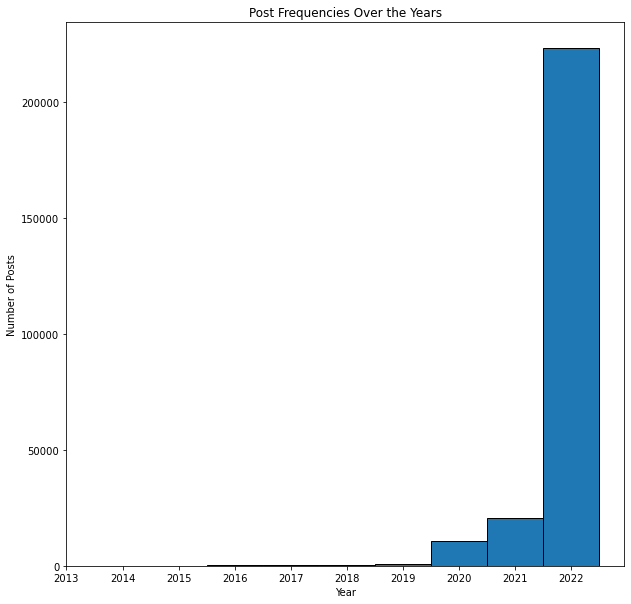

In [20]:
plt.figure(figsize=(10,10))
plt.title('Post Frequencies Over the Years')
plt.xlabel('Year', loc='center')
plt.ylabel('Number of Posts')
plt.hist(x=df['year'], bins=9, align='right', edgecolor='black')
plt.xticks([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]);

Can definitely see the massive increase in post frequency from 2021 to 2022

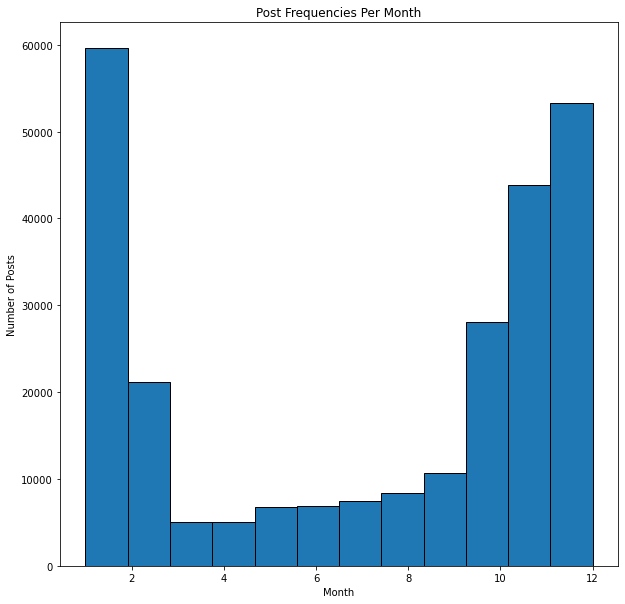

In [21]:
plt.figure(figsize=(10,10))
plt.title('Post Frequencies Per Month')
plt.xlabel('Month', loc='center')
plt.ylabel('Number of Posts')
plt.hist(x=df['month'], bins=12, edgecolor='black');
#plt.xticks([1, 2,3,4,5,6,7,8,9,10,11,12]);  # Set text labels and properties.

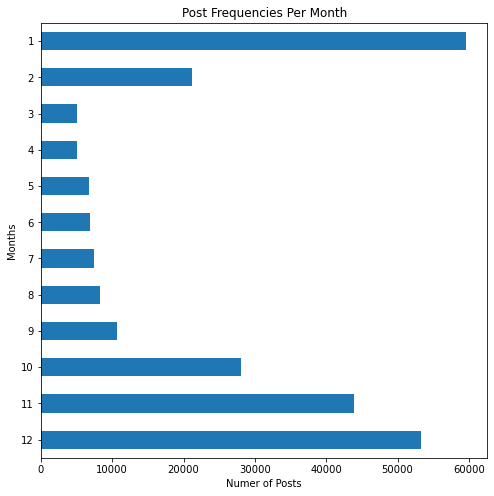

In [22]:
plt.figure(figsize=(8,8))
plt.title('Post Frequencies Per Month')
plt.xlabel('Numer of Posts', loc='center')
plt.ylabel('Months')
df['month'].value_counts().sort_index(ascending=False).plot.barh();

These two charts show us that the winter months seem to have more posts. 

<a name=’Preprocessing’></a>
## III: Preprocessing

In [23]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS

# NLTK
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
# stop_words = stopwords.words('english')
# stop_words.extend(['work', 'job', 'www', 'com', 'https', 'antiwork', 'amp'])

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
#warnings.simplefilter("always", append=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#Adding some personal stop words since these words contributed to creating a topic that doesn't make the most sense.

my_stop_words = STOPWORDS.union(set(['work', 'job', 'www', 'com', 'https', 'antiwork', 'amp', 'delete', 'post', 'working', 'worked', 'works','worker']))

Tokenizing, stemming, lemming

In [25]:
# function structure from
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    text = re.sub('\s+', ' ', text)  # remove newline chars
    text = re.sub("\'", "", text)  # remove single quotes
    #tokenizer = RegexpTokenizer('\w+') #tokenize at word boundaries
    text = text.lower()
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in my_stop_words and len(token) >= 3:
           # print(token)
            result.append(lemmatize_stemming(token))
    return result

Test case to ensure preprocessing worked properly. I added a custom stop word to this test case to ensure my custom stop words work properly

In [26]:
test = "www.Democracy ''is a lie, especially in the modern workplace work"
test

"www.Democracy ''is a lie, especially in the modern workplace work"

In [27]:
print(preprocess(test))

['democraci', 'lie', 'especi', 'modern', 'workplac']


It works! Applying the preprocessing function to the df

In [28]:
preprocessed = df['title_w_text'].map(preprocess)
preprocessed

0         [neon, museum, las, vega, take, away, tip, hir...
1                                                        []
2         [kind, feel, like, scream, cyberspac, new, job...
3                [democraci, lie, especi, modern, workplac]
4         [master, degre, pay, rais, boss, ask, today, p...
                                ...                        
256274                                 [abolit, bob, black]
256275                        [global, campaign, hour, day]
256276                                   [polit, get, life]
256277                                          [new, anti]
256278    [idl, theori, appli, theori, evolut, approach,...
Name: title_w_text, Length: 256279, dtype: object

In [29]:
df['preprocessed'] = preprocessed
df.head()

,id,created_utc,permalink,url,score,title_w_text,year,month,length,preprocessed
0,svw6x3,2022-02-18 23:58:39,https://old.reddit.com/r/antiwork/comments/svw...,NaN,15,Neon Museum Las Vegas took away our tips I was...,2022,2,1891,"[neon, museum, las, vega, take, away, tip, hir..."
1,svw6jv,2022-02-18 23:58:07,https://old.reddit.com/r/antiwork/comments/svw...,https://i.redd.it/vuoctaq0koi81.png,1887,Working,2022,2,8,[]
2,svw5e8,2022-02-18 23:56:28,https://old.reddit.com/r/antiwork/comments/svw...,NaN,4,Kind of feel like screaming into the cyberspac...,2022,2,3106,"[kind, feel, like, scream, cyberspac, new, job..."
3,svw498,2022-02-18 23:54:55,https://old.reddit.com/r/antiwork/comments/svw...,https://i.redd.it/1w1unxjfjoi81.png,14060,"Democracy is a lie, especially in the modern w...",2022,2,55,"[democraci, lie, especi, modern, workplac]"
4,svw3qt,2022-02-18 23:54:10,https://old.reddit.com/r/antiwork/comments/svw...,NaN,63,Master's Degree - No Pay Raise but OT My boss ...,2022,2,339,"[master, degre, pay, rais, boss, ask, today, p..."


<a name='Modeling'></a>
# IV: Modeling
### Running LDA on the tokenized, stemmed, and lemmed words of the whole corpus
#### 5 clusters

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(preprocessed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in preprocessed]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           workers=3,
                                           random_state=42,
                                           chunksize=256,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.025*"compani" + 0.022*"pay" + 0.013*"year" + 0.012*"employ" + '
  '0.011*"employe" + 0.009*"hour" + 0.009*"interview" + 0.008*"new" + '
  '0.007*"time" + 0.007*"posit"'),
 (1,
  '0.030*"day" + 0.020*"time" + 0.020*"hour" + 0.019*"week" + 0.015*"get" + '
  '0.013*"tell" + 0.012*"boss" + 0.012*"like" + 0.011*"go" + 0.010*"manag"'),
 (2,
  '0.012*"worker" + 0.010*"peopl" + 0.010*"capit" + 0.009*"remov" + '
  '0.009*"labor" + 0.008*"anti" + 0.006*"sub" + 0.006*"union" + 0.006*"world" '
  '+ 0.005*"societi"'),
 (3,
  '0.011*"fuck" + 0.011*"food" + 0.009*"custom" + 0.008*"store" + 0.008*"car" '
  '+ 0.007*"busi" + 0.007*"buy" + 0.006*"watch" + 0.006*"drive" + '
  '0.005*"shit"'),
 (4,
  '0.020*"like" + 0.020*"delet" + 0.020*"peopl" + 0.018*"life" + 0.016*"want" '
  '+ 0.015*"dont" + 0.015*"live" + 0.013*"time" + 0.012*"think" + '
  '0.012*"feel"')]


In [31]:
#!pip install pyLDAvis
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models

#### Reading the pyLDAvis

pyLDAvis is a visualization method used to simplify visualizing the topics the LDA model produces. On the left side of the visual, each circle represents a topic where the larger the circle, the more documents the topic has so to speak. The closer the circles are, the more closely related the topics are. If there is overlap, the topics have something in common.

On the right side, the most common terms are shown. If no topic is selected, it's the most common terms of the whole corpus. When you select a topic from the left, the terms most prevalent to that topic appear. The red bar is showing how the frequency of that term within that topic, whereas the blue bar is showing the term frequency within the corpus. If you hover/click a term, the topic circles where that term is found grow larger. The larger the circle, the more frequently that word is in that topic.

The relevance metric slider, denoted with a lambda, ranges on a scale of 0.0 to 1.0. As you move the scale towards 0, the terms that will appear are more exclusive to the topic that is selected meaning you will start to see more red bars. As the scale is moved toward 1, the terms that appear are not only relevant to the topic, but to the corpus as a whole.

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)

pyLDAvis.display(vis)

These are the overarching topics from the inception of the antiwork subreddit in 2013, up until February of 2022.

Topic 1: 
- This topic seems to be centered around __how much time in a day/week they are putting in__. The terms most relevant to the topic are day, week, boss, hour, time, sick, call, shift, the lemma "cowork", and weekend, just to name a handful. 
- Potential recommendations for an employer would be to have clear and strict working hours, providing appropriate time off, encouraging taking time off, but without adding unnecessary pressure on other employees.

Topic 2: 
- This topic seems to be centered around employees' __benefits, salaries, raises, and offers they are receivin__. Key terms include the lemma "compani", the lemma "employe" which could mean employee, employer, or employed, the lemma "rais", offer, the lemma "salari", minimum, benefit, the lemma "increas", contract, the lemma "resum", and bonus. These terms all connect to financial benefits. 
- Possible recommendations include delivering an offer that is what an employee asks, having a clear pay raise schedule/requirements, providing opportunities for raises and bonus', and having efficient benefit plans.

Topic 3: 
- This topic has a good amount of deleted posts which is told by the lemma "delet" which is how posts deletd by the user will show when scraping the subreddit.  This topic seems to be concerned with the __emotions of employees__ since there are very emotional terms such as "hate" and "love" being almost exclusively found in this topic. It can also be possible that users were ranting, then had changed their minds about their rant being on the subreddit so they deleted it.
- Possible recommendations include providing spaces for employees to express themselves without fear of dismissal or gaslighting which could possibly include an in house mental awareness coach, or providing social opportunities so theres space to be more human and less of a worker-bee.

Topc 4: 
- This topic has a good amount of removed posts which is told by the lemma "remov" which is how posts removed by moderators will show when scraping the subreddit. These posts could have been removed for possibly being too radical as this topic seems largely concerned with __large scale issues with the "system"__. Capitalist and capitalism arise almost exclusively in this topic. As does american, economy, union, protest, coronavirus, and abolish. This topic is fairly far apart from the other topics as well so it's pretty dinstint.
- Recommendations for addressing these topics could include doing something to ensure that your employees don't see themselves as "just a number" or "part of the system". Do things that make them feel appreciated, important, and valuable such as asking their opinions when possible, giving bonuses for the holidays or for returning next fiscal year. These are some ideas that could make employees feel as if their companies are sharing the wealth opposed to solely making money off of their work.

Topic 5: 
- Topic 5 does not have the clearest distinction. Words more exclusive to this topic are restaurant, tip, the lemma "groceri", and food. Possibly the service industry employees unhappy about aspects of their jobs? This is a very distinct topic and pretty unclear.

Due to the immense overlap in topics 2 and 3, I am rerunning the model with 4 topics instead of 5 to see if there is better distinction

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(preprocessed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in preprocessed]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           workers=3,
                                           random_state=42,
                                           chunksize=256,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)

pyLDAvis.display(vis)

#### Four models seems to be clearer and more distinct differentiation and therefore a better representation of the overarching topics of the antiwork subreddit.

Topic 1: 
- This topic did not change too much from the original topic 1, but it is larger with 39.9% of tokens belonging to this topic vs 34.3% when training the model with 5 topics. The topic is still centered around centered around __how much time in a day/week they are putting in__ with key terms being day, week, boss, hour, sick, the lemma "home", and the lemma "manag".
- Potential recommendations for an employer would be to have clear and strict working hours, providing appropriate time off, and encouraging taking time off opposed to encouraging putting in too many hours.

Topic 2: 
- This topic did not change too much from the original topic 2, and still seems to be centered around employees' __pay, offers they are receiving, and benefits__. Key terms still include the lemma "compani", the lemma "employe" which could mean employee, employer, or employed, the lemma "rais", offer, the lemma "salari", benefit, and interview. These terms all connect to financial benefits. The term interview, however, leads me to wonder if these are all concerns voiced by potential employees who did not like the employment process, or possibly even employees who feel like the company needs to interview more to increase employee counts.
- Possible recommendations include delivering an offer that is what an employee asks, having a clear pay raise schedule/requirements, providing opportunities for raises and bonus', having efficient benefit plans, and possibly making the interview/employment process as streamlined as possible.

Topic 3:
- this topic seems largely concerned with __large scale issues with the "system"__. The terms union, american, the lemma "slaveri", society, the lemma "capit" and the word capitalism, union, labor, and strike. These terms lead me to believe employees have concerns with the overall structure of company culture, specifically capitalistic ideologies and have considerd labor unions.
- Recommendations for addressing these topics could include doing something to ensure that your employees don't see themselves as "just a number" or "part of the system". Do things that make them feel appreciated, important, and valuable such as asking their opinions when possible, giving bonuses for the holidays or for returning next fiscal year. These are some ideas that could make employees feel as if their companies are sharing the wealth opposed to solely making money off of their work.

Topic 4: 
- This topic also has a lot of deleted posts which is told by the lemma "delet" which is how posts deletd by the user will show when scraping the subreddit. This topic seems to concerned with __work-life balance and having emotional support__. Terms such as  the lemma "depress",life, live, hate, dream, and passion are all very emotionally charged.
- Possible recommendations include providing spaces for employees to express themselves without fear of dismissal or gaslighting which could possibly include an in house mental awareness coach, or providing social opportunities so theres space to be more human and less of a worker-bee. These recommendations would likely pair best with coupling time off/less time on the job.

In [44]:
p = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(p, './pyLDAvis/lda_all.html')

## i: LDA on the years 2019-2021

I chose to break down into these years to see if the pandemic or any other events had any innfluence on the topics.

In [35]:
df19 = df[df['year']==2019]
df19.shape

(10481, 10)

In [36]:
# Create Dictionary
id2word = corpora.Dictionary(df19['preprocessed'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df19['preprocessed']]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           workers=3,
                                           random_state=42,
                                           chunksize=256,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#pprint(lda_model.print_topics())


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)

pyLDAvis.display(vis)

Topic 1: 
- This topic is still  overall about the __emlployee's time__ and the biggest topic. The words that are more exclusive to this topic that tell a clear story are day, hour, week, feel, time, sleep, weekend, mental, month, and home. This topic is closely related to topic 2 and has slight overlap. 
- Potential recommendations for an employer would be to have clear and strict working hours, providing appropriate time off, encouraging taking time off, but without adding unnecessary pressure on other employees.

Topic 2: 
- Has a small amount of crossover with topic 1, but minimal. The terms most relevant in this second largest topic include society, human, retire, planet, live, buy, value, and house. These terms give me a narrative concerning the __financial sustainability__ a job is providing. It's possible the employees don't feel like their futures are being invested in.
- Recommendations for addressing this topic could include doing something to ensure that your employees don't see themselves as "just a number" or "part of the system". Provide opportunities that give the message of being invested in employees' futures such as opportunities for professional development without having to take time off, asking their opinion when relevant, or problem solving together opposed to providing the hard fast solution.

Topic 3: 
- This topic has a good amount of deleted posts which is told by the lemma "delet" which is how posts deletd by the user will show when scraping the subreddit. The most important terms of this topic are the lemma "employe", interview, email, application, the lemma "manag" so something concerning management, and hire. These terms lead me to believe this topic is about the __employment/application process__.
- Recommendations to address this topic could include streamlining the application process to make it as simple and straightforward as possible, consistent communication with applicants, and have a smooth hiring and training process that best prepares the employee for the position they were hired for.

Topic 4: 
- This topic seems to lean very heavily __towards political issues/workplace reform__. A very interesting find in this topic is the mentioning of Japan. They had a huge labor law reform happen in 2019 that included increased benefits, cracking down on overtime allowed, increasing overtime pay, and more which can be read about here: https://www.globalpeoplestrategist.com/significant-changes-to-japan-labor-laws/. Other terms such as Andrew, and yang, who was a democratic candidate for the 2020 election, trump,  strike, american, union, communism, anarchist, etc. provide the narrative that politics can become a huge part of the workplace. The terms american, the lemma "economi", and union also contribute to this narrative.
- Recommendations to address this are simple: listen to what employees ask for. Host surverys that are without reprimand that allow for data to be collected and changes to be made. Without reprimand includes without requiring employee time on trainings that wont' benefit the employees as well because taking time is a reprimand. 

In [37]:
p = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(p, './pyLDAvis/lda2019.html')

### 2020

In [38]:
df20 = df[df['year']==2020]
df20.shape

(20679, 10)

I ran 2020 LDA with three topics because 4 topics had a lot of crossover.

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(df20['preprocessed'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df20['preprocessed']]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           workers=3,
                                           random_state=42,
                                           chunksize=256,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#pprint(lda_model.print_topics())


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)

pyLDAvis.display(vis)

Topic 1: 
- Topic 1 is consistently overall about the __emlployee's time__ and the biggest topic. The words that are more exclusive to this topic that tell a clear story are "day", "hour", "week", "feel", "time", "sleep", "weekend", "mental", "month", and "home". 
- The potential recommendations for an employer remain the same. Have clear and strict working hours, providing appropriate time off, encourage taking time off, but without adding unnecessary pressure on other employees. Possibly giving employees time back when possible could also assist in alleviating this concern.

Topic 2: 
- Topic 2 is still concerning the __financial sustainability__ and the __possible lifestyle__ the job can offer. Terms such as human, world, life, live, the lemma "capit" which could likely refer to having capital, income, wealth, freedom, education, etc. lead me to this summation.
- Recommendations for addressing this topic could include doing something to ensure that your employees don't see themselves as "just a number" or "part of the system". Provide opportunities that give the message of being invested in employees' futures such as opportunities for professional development without having to take time off, asking their opinion when relevant, or problem solving together opposed to providing the hard fast solution. Providing access to places like coursera or udemy, offering some type of student loan forgiveness, or assistance/encouragement of employees furthering their education could make employees feel invested in.

Topic 3: 
- Topic 3 also had many deleted posts which is told by the lemma "delet" which is how posts deletd by the user will show when scraping the subreddit. The terms that make this topic most unique are union, strike, coronavirus, the lemma "societi",  and capitalist. This narrative seems to be aligned with how __society is handling the pandemic and what employees are considering doing about it__. It's a possible narrative that employees feel as if companies are more concerned about the companies bottom line instead of their employees. It is expected in the year 2020 to see coronavirus as a common word, but somewhat surprising that it's the smallest topic.
- Recommendations for this topic could include asking employees if they feel physically and mentally safe in the workplace, and/or what could make them feel safer. As well as ensuring employees feel valued and appreciated. The best way to ensure they feel valued/appreciated is simply to ask what would make them feel valued, then make strides to do that.

In [40]:
p = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(p, './pyLDAvis/lda2020.html')

### 2021

In [41]:
df21 = df[df['year']==2021]
df21.shape

(151533, 10)

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(df21['preprocessed'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df21['preprocessed']]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           workers=3,
                                           random_state=42,
                                           chunksize=256,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#pprint(lda_model.print_topics())


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)

pyLDAvis.display(vis)

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/conda/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/conda/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = Loose

Topic 1: 
- Topic 1 is consistently overall about the emlployee's __time__. The words that are more exclusive to this topic that tell a clear story are day, hour, week, shift, time, home, sick, and break.
- Potential recommendations for an employer would be to have clear and strict working hours, providing appropriate time off, encouraging taking time off, but without adding unnecessary pressure on other employees.

Topic 2: 
- Topic 2 has a lot of overlap with topic 1, but also highlights what seems to be the __employment process__. Words like position, interview, the lemma "appli", the lemma "salari", and the lemma "rais" guide this narrative. 
- Recommendations to address this topic could include streamlining the application process to make it as simple and straightforward as possible, consistent communication with applicants, and have a smooth hiring and training process that best prepares the employee for the position they were hired for.

Topic 3: 
- Topic 3 seems to be centered around __not being paid fairly__. The terms money, slave, minimum, the lemma "wag", the lemma "surviv", labor, the lemma "incom", profit and rich all contribute to that narrative. 
- Recommendations include ensuring employees are paid what they are worth and a livable income.

Topic 4:
- Topic 4 is the smallest and least definitive topic with a very large amount of deleted and removed posts. Terms such as strike and union show up exclusively in this topic, as are terms amazon and the lemma "bezo" which almost certainly is referring to Jeff Bezos. These terms, coupled with the lemma "capit" lead me to believe this topic is about capitalism and "the rich getting richer while the poor get poorer". This topic is likely concerning __systemic issues__.

In [46]:
p = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(p, './pyLDAvis/lda2021.html')

## V: Performing Sentiment Analysis on the Years 2019-2021 

In [47]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [48]:
#function courtesy of Katie Sylvia
def sentiment(row):
    analyzer = SentimentIntensityAnalyzer()
    res = analyzer.polarity_scores(row)
    return pd.Series([res['compound']])

- Comp score greater than 0.05 is positive

- comp score between -0.05 and 0.05 is neutral

- comp score less than  -0.05 considered negative

In [ ]:
df[['comp']] = df['title_w_text'].apply(sentiment)

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/conda/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/conda/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = Loose

In [ ]:
df

After performing sentiment analysis on the corpus and visualizing it on Tableau (below), I noticed the majority of time, the sentiment was negative (less than -0.05) where the last time there was positive sentiment within r/Antiwork was October of 2018. Over the years however, sentiment is approaching a general neutrality which is arguably better than generally negative. On the other hand, neutrality could suggest employees are becoming complacent. When complacent for too long, it's possible to become bored. For some, that could mean resignation which employers typically avoid.

In [ ]:
%%html
<div class='tableau Placeholder' id='viz1650050136705' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;an&#47;antiwork&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='antiwork&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;an&#47;antiwork&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1650050136705');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.maxWidth='1250px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='887px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [ ]:
#saving this df to use on tableau
df.drop(columns=['preprocessed']).to_csv('./data/cleaned_processed_sentiment_df_posts.csv', index=False)

In [ ]:
#df.isna().sum(

In [ ]:
df.head()

In [ ]:
df_test = pd.read_csv('./data/cleaned_processed_sentiment_df_posts.csv')
df_test.drop(columns=['permalink', 'url', 'title_w_text'], inplace=True)

In [ ]:
df_test.to_csv('./data/tableau.csv', index=False)

# Conclusions and Recommendations

All in all, there are three recurring root causes of employees being unhappy at their workplaces. The most consistent topics were the employees' time, financial stability, and systemic concerns within their workplace. The concerns of time were incredibly and profoundly consistent, whereas the concerns of financial stability had slight change throughout the years, and the systemic concerns varied as the years went on. Below are specific conclusions and recommendations on these concerns.

When it came to the topic of time, this was the number 1 topic  in the entire corpus, and consistently the number 1 topic in every model for the years 2019-2021. Terms that continuously appeared when discussing time were:
- day, 
- hour, 
- week, 
- shift, 
- time, 
- home, 
- sick,  
- break
- sleep, 
- weekend, 
- mental, and
- month

Potential recommendations for an employer to handle the concern of employees' time could first be to have clear and strict working hours. If your company has working hours of 8 am to 5 pm Monday through Friday, encourage and support clocking out at 5 pm. If its noticed work is still being done after 5 pm, an employer could ask what support they could provide in assisting the employee in accomplishing their tasks and goals within the work day. This build to another recommendation of ensuring an employer is being cognizant of their time when providing tasks, scheduling meetings, etc. For example, if tasks and responsibilities require 6 hours of an 8 hour work day, it would not be cognizant to schedule more than 2 hours of meetings in a day. Another recommendation could be to ensure an employer is providing appropriate time off. That could mean sick time is different from traditional paid time off/vacation time. Provide the opportunities for employees to take time, but also encouraging taking time off. Like we noticed in 2019, there was a lot of talk about Japan's workplace reform laws which included time off _requirements_ for employees. These could all be steps in showing that employers don't need nor expect an employee to give _all_ of their time to their place of work.


The second largest and consistent topic of concern was the financial stability an employee feels they have. This topic was talked about in some way shape or form throughout the years. The terms seen in this topic were: 
- money, 
- wage, 
- profit,
- life,
- live, 
- income, 
- wealth, 
- freedom, 
- retire, 
- buy, 
- value, 
- house
- education, and
- "capit"

These are all about money, but with a connotation of the future. Employees want to know their future in being invested in, the same way they invest their time with an employer. Recommendations for employers to give the message of being invested in their employees' futures could include doing something to ensure that your employees don't see themselves as "just a number" or "part of the system". Do things that make them feel appreciated, important, and valuable such as asking their opinions when possible, giving bonuses for the holidays or for returning next fiscal year, and regularly providing opportunities for employees to provide meaningful feedback, then acting on it. Employers could provide opportunities for professional development without having to take time off, or provide access to and encourage use of online learning places such as Coursera or Udemy. Another way an employer could show they care about the financial stability of their employess is to offer some type of student loan forgiveness, or assistance/encouragement of employees furthering their education. These are some ideas that could make employees feel as if their companies are sharing the wealth opposed to withholding the fruits of their labor.

Lastly, the third most consistent topic was centered around systemic concerns. Sometimes these concerns were political and concerning capitalism, like we saw in the year 2021 where jeff bezos was brought up often. Other times the concerns were centered around workplace culture like we were seeing in 2020 where union and strike were very common, and especially in 2019 where employees were talking very heavily about the new Japanese workplace reform policies. The terms that were seen in this topic were: 
- strike, 
- union,
- "societi", 
- capitalist
- american, and
- "economi"

While these terms were found consistently, the specifics of the systemic concerns changed between 2019 and 2021 depending on what was going on in the world at the time. The biggest recommendation to remedy this topic is to host surveys that are without reprimand that allow for data to be collected and changes to be made. Without reprimand includes not requiring employee time on trainings that wont' benefit the employees as well because taking time is a reprimand. When big events are happening, such as a pandemic, employers could ask employees if they feel physically and mentally safe in the workplace, and/or what could make them feel safer. Employers could make it systemic to be concerned about their employees instead of employees being concerned about the systemics of their employers.

# Next Steps

This model can be fed new documents without having to be retrained, so I would continue to monitor r/Antiwork and add documents to the corpus. This would allow me to see how the topics are shifting, or remaining the same, with time. I would also like to extract text from images as there a lot of meaningful words within the images, and I would also like to retrain the model using n grams and increasing the iterations of the model training.

##### end

Click [here](#Using-Latent-Dirichlet-Allocation-(LDA)-to-Topic-Model) to return to the top of the notebook.